# Histopathologic Canger Detection

### Project Description

This is a kaggle competition (https://www.kaggle.com/c/histopathologic-cancer-detection/overview) aimed at classifying medical pathology scans as metastatic cancer or not. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

This will be a binary image classification problem and I will use a CNN created with keras.

You can find this notebook here on github: https://github.com/emhi6821/DL_Week3_CNN_Cancer/blob/main/Histopathologic%20Cancer%20Detection.ipynb

I start off by importing the necessary python libraries for my work below.

In [183]:
import numpy as np 
import pandas as pd
import os
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from glob import glob
from random import shuffle
import cv2
import keras
import numpy as np
import pandas as pd
from PIL import Image
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.initializers import he_normal
from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D, ReLU)
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
import tensorflow as tf

## Data Import & Exploration

The dataset(PCam), packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST.

## Exploratory Data Analysis & Preprocessing

I will start off with some exploratory data analysis to familiarize myself with what is included in the data and the formats of the data and also to ensure that it is in the format we want for training.

In [89]:
#Lets start off by looking at what is included in the train and test labels.cvs
#I want to start off by seeing what the train test split is and then will probably split test into test and val also

train_df = pd.read_csv("data/train_labels.csv")
test_data = glob("data/test/*")

id_label_map = {k:v for k,v in zip(train_df.id.values, train_df.label.values)}
print(train_df.head())

print('\n\n# of Training Data: ', len(train_df))
print('# of Test Data: ', len(test_data))

print('Training % of total data: ', round(len(train_df)/(len(train_df) + len(test_data)),3))
print('Test % of total data: ', round(len(test_data)/(len(train_df) + len(test_data)),3))

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


# of Training Data:  220025
# of Test Data:  57458
Training % of total data:  0.793
Test % of total data:  0.207


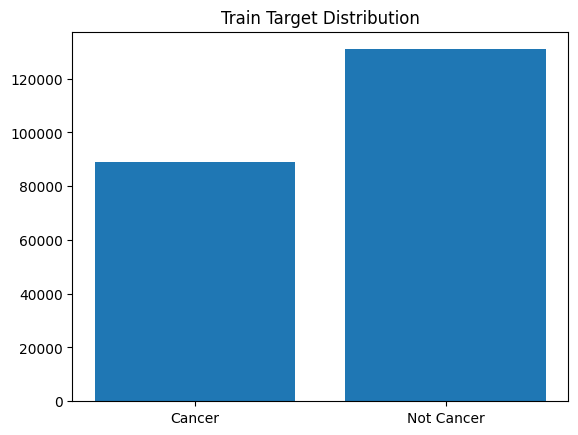

In [262]:
plt.bar(['Cancer', 'Not Cancer'], [train_df['label'].sum(), len(train_df)-train_df['label'].sum()])
plt.title('Train Target Distribution')
plt.show()

You can see from what I have printed in the cell above that there is a unique id for each image that we want to classify an an associated binary label. Also, you can see we have 220,025 Training images/labels and 57,458 test images/labels. This is equivelant to about 80/20 split between train/test. There are only two columns in the train labels dataset and they seem to already be in a format that will be acceptable for creating keras datasets (unique id string and bool/int).

I want to create a validation dataset also out of the training data. I am going to take about 15% for validation which would make our train/val/test split about 65/15/20. This means I need to take about 18.5% from the training data to make validation dataset.

The first line of the next cell is creating an additional column in train_df which has the path to the image. 

I am also setting up a dataframe for the test data with fake labels for not just to be able to use the same flow from dataframe functionality for predictions later.

In [292]:
train_df["path"] = train_df["id"].apply(lambda x:  x + ".tif")

train_imgs = glob('data/train/*.tif')
test_imgs = glob('data/test/*.tif')

train, val = train_test_split(train_df, test_size=0.185, random_state=177)
total = len(train)+len(val)+(len(test_imgs))

print('Train % :', round(len(train)/total,3))
print('Validation % :', round(len(val)/total,3))
print('Test % :', round(len(test_imgs)/total,3))

#Reset the indexes for the new split dataframes
train.reset_index(drop=True)
val.reset_index(drop=True)

train.label = train.label.astype(str)
val.label = val.label.astype(str)

test_files = [x.split('/')[-1] for x in test_files]
test = pd.DataFrame({'path': test_files, 'label': '0'})
test.loc[0,'label']='1'

Train % : 0.646
Validation % : 0.147
Test % : 0.207


Above I changed the type of the label column to string because that is what the image data generator from keras wants if we use the binary class mode. Below I am choosing a batch size of 32 and setting the image size before creating the image generators that we will use for training. You can see the # of images for train and val printed below the cell below and confirmation that the dataset has two classes.

In [294]:
image_shape = (96, 96, 3)
batch_size = 32

img_gen = ImageDataGenerator(rescale=1.0 / 255,
    samplewise_center=True,
    samplewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip=True)

train_flow = img_gen.flow_from_dataframe(dataframe=train,
    directory="data/train",
    x_col="path",
    y_col="label",
    has_ext=True,
    class_mode = 'binary',
    target_size=image_shape[:2],
    batch_size=batch_size)

val_flow = img_gen.flow_from_dataframe(dataframe=val,
    directory="data/train",
    x_col="path",
    y_col="label",
    has_ext=True,
    class_mode = 'binary',
    target_size=image_shape[:2],
    batch_size=batch_size,
    shuffle=False)

test_flow = img_gen.flow_from_dataframe(dataframe=test,
    directory="data/test",
    x_col="path",
    y_col="label",
    has_ext=True,
    class_mode = 'binary',
    target_size=image_shape[:2],
    batch_size=batch_size,
    shuffle=False)

Found 179320 validated image filenames belonging to 2 classes.
Found 40705 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames belonging to 2 classes.


Just want to view some of the data below. See the scans plotted. This will show 1 batch worth of data with the label as the title. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


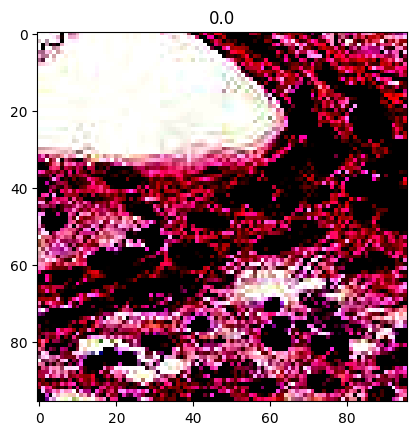

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


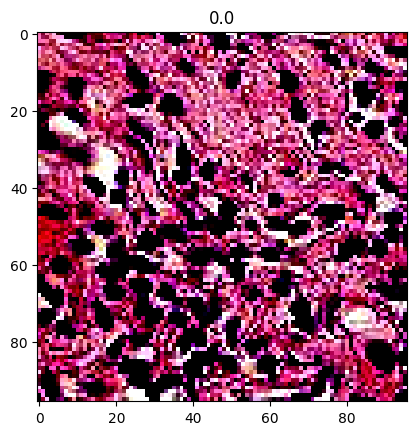

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


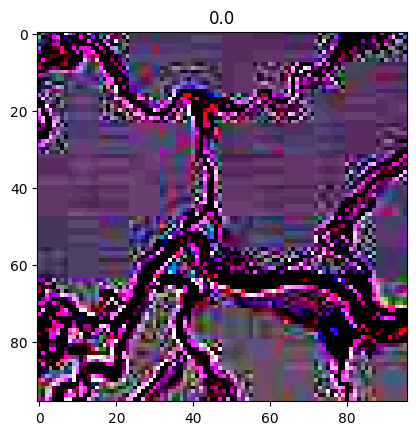

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


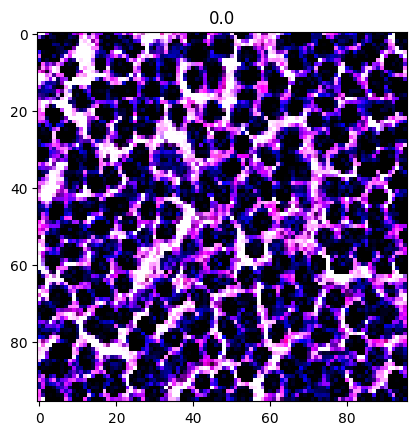

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


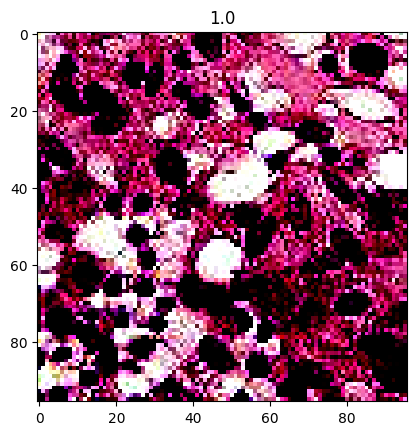

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


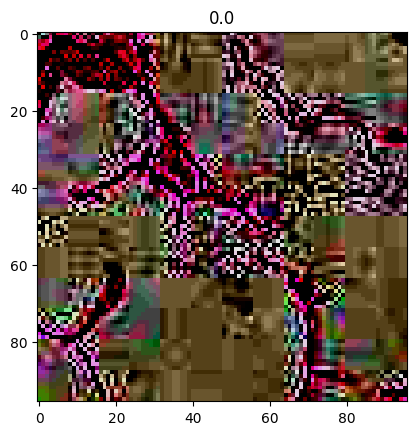

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


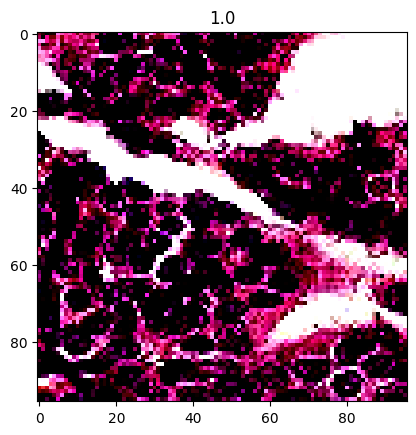

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


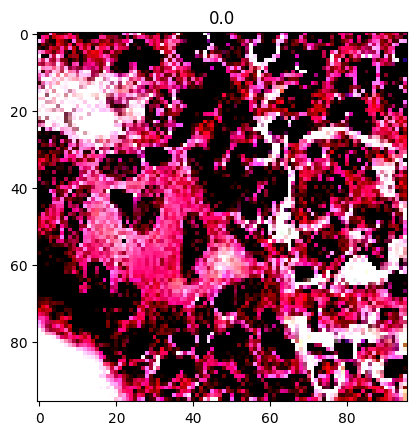

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


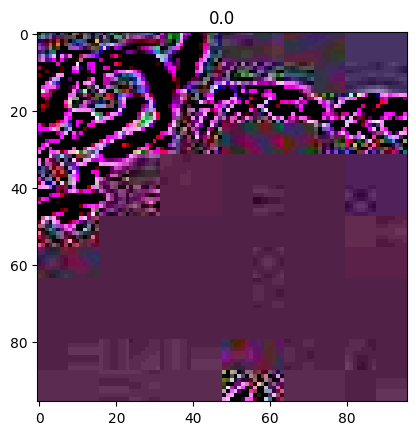

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


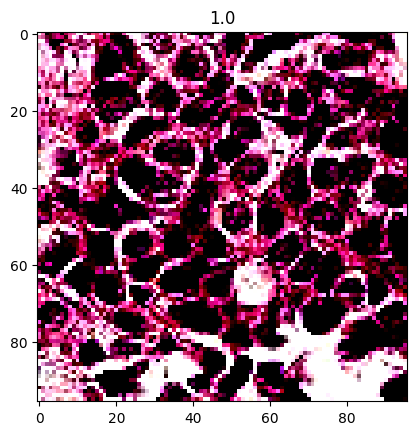

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


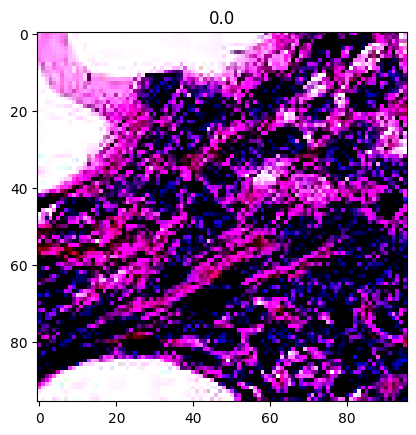

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


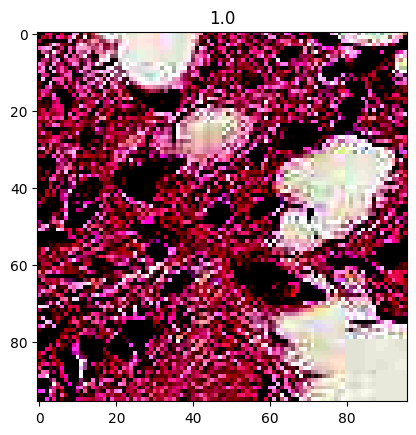

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


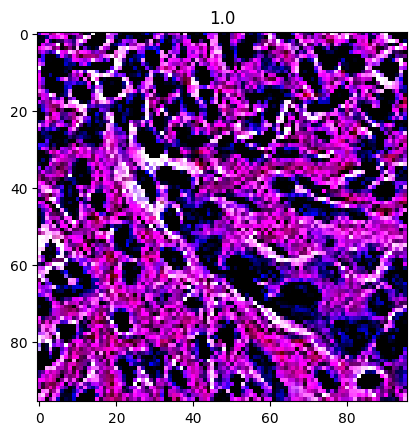

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


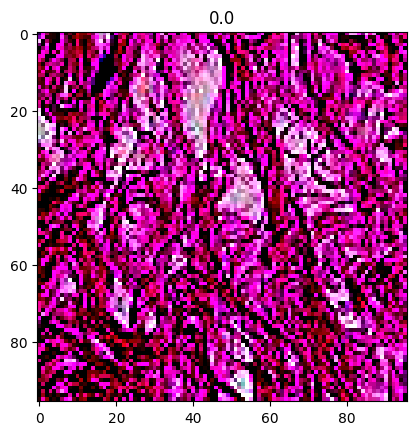

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


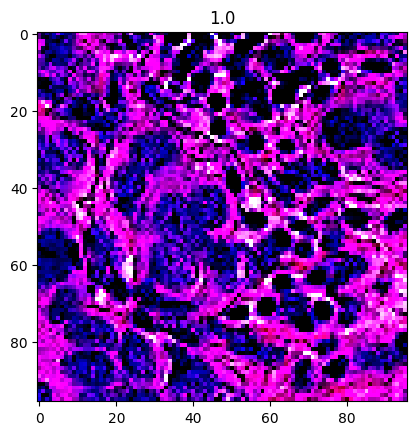

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


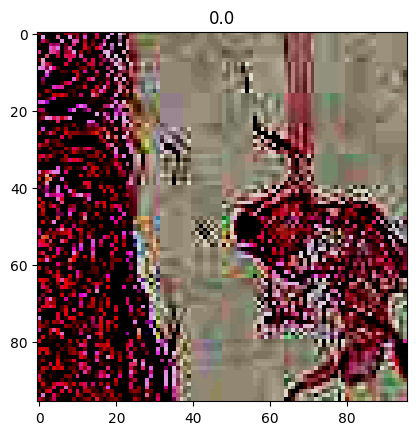

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


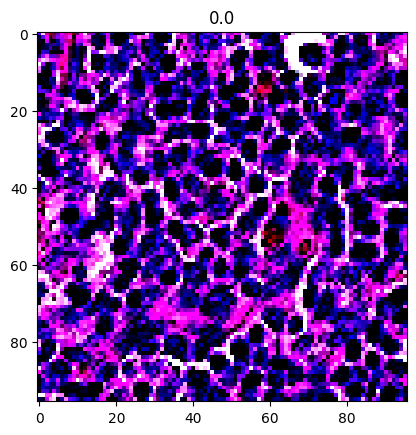

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


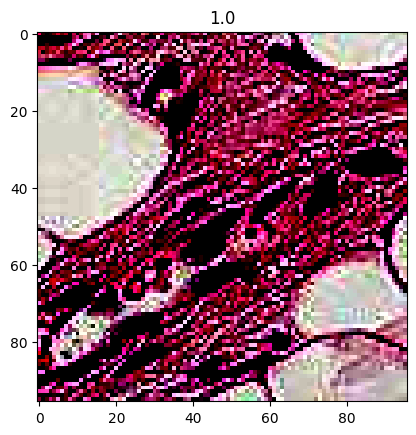

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


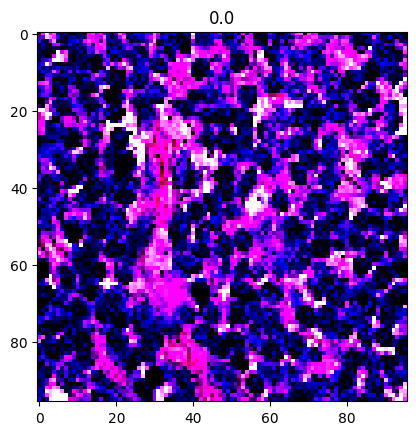

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


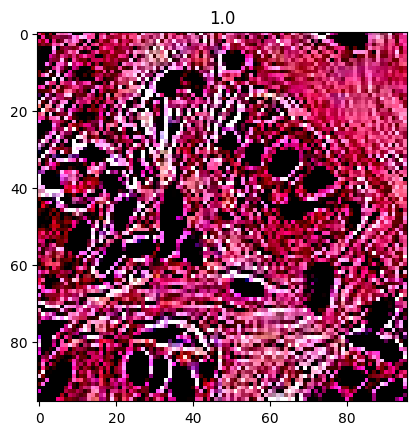

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


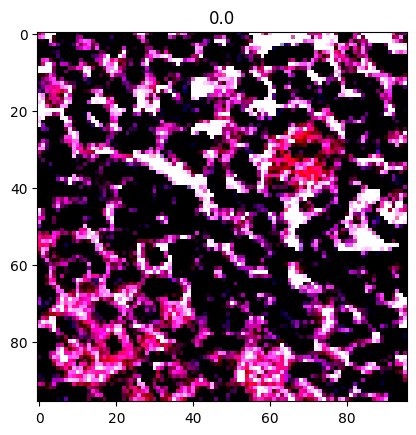

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


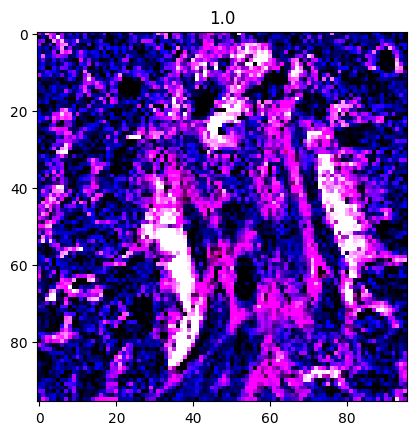

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


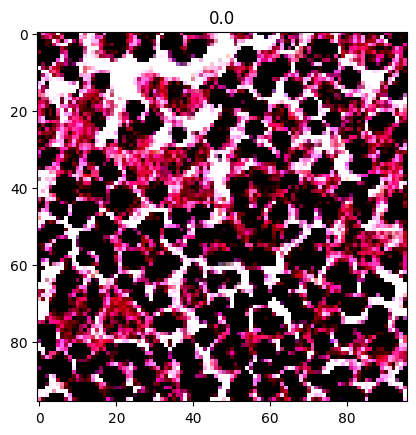

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


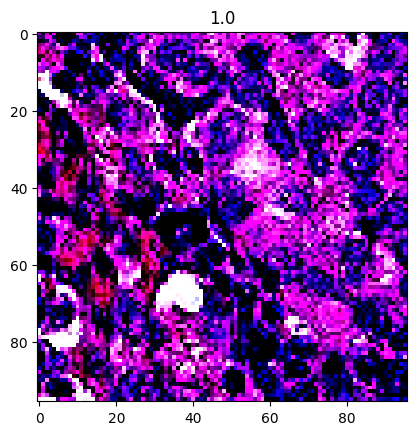

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


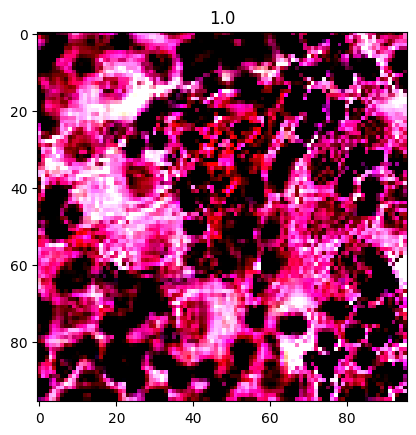

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


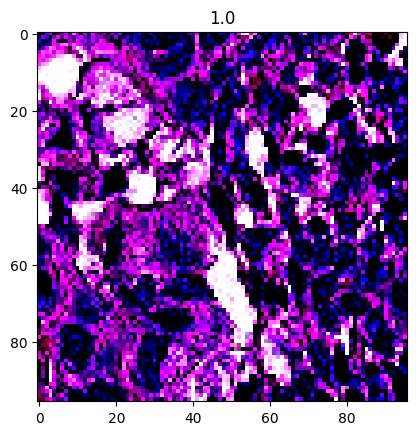

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


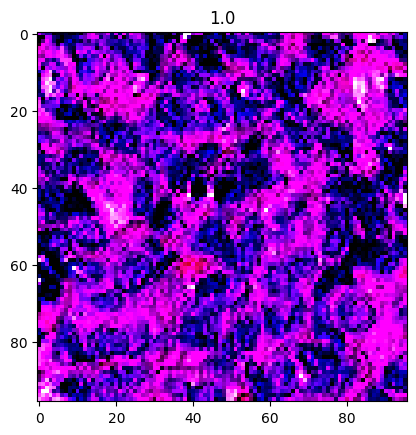

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


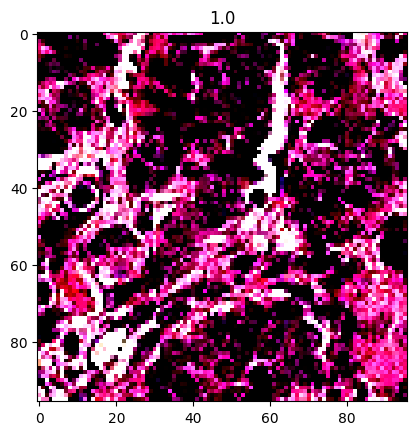

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


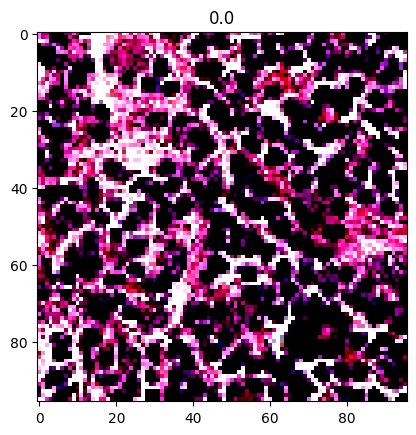

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


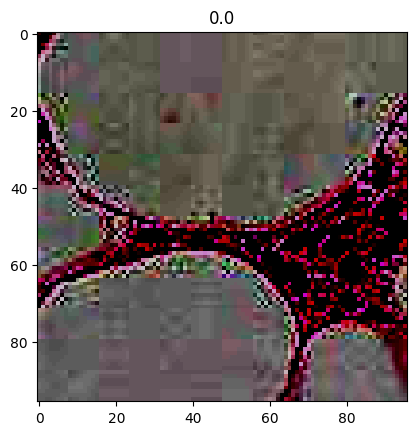

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


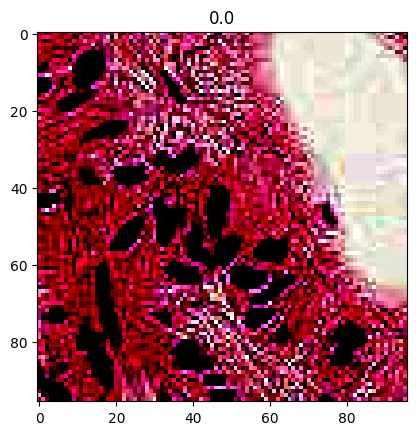

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


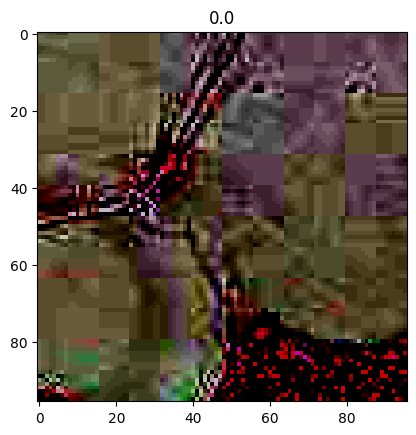

In [146]:
x, y = train_flow.next()
for i in range(len(x)):
    image = x[i]
    plt.imshow(image)
    plt.title(y[i])
    plt.show()

## Build Model, Hyperparemeter Tuning & Fitting

Now lets start building the model. The model has multiple convolutional layers 256, 512, 728 and 1024 filters, followed by batch normalization and ReLU activation. Lastly is a fully connected layer with normalization, dropout and relu activation. I tried multiple learning rates and landed on  ### and I am using categorical cross-entropy for the loss function. See summary of the model below. I did not loop through different hyparemeter selections to tune the hyperparemeters for this model because I have used it before for a similar dataset and have already selected the hyperparemeters appropriately. 

In [124]:

num_classes = 2
inputs = keras.Input(shape=image_shape)

# Entry block
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
# We specify activation=None so as to return logits
outputs = layers.Dense(1, activation=None)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 96, 96, 3)            0         ['input_6[0][0]']             
                                                                                                  
 conv2d_62 (Conv2D)          (None, 48, 48, 128)          3584      ['rescaling_5[0][0]']         
                                                                                                  
 batch_normalization_96 (Ba  (None, 48, 48, 128)          512       ['conv2d_62[0][0]']           
 tchNormalization)                                                                          

Next compile the model, integrate callbacks and fit the model. I am using an early stopper, learning rate decay which automatically reduces the learning rate on a plateau of validation accuracy, a csv logger and checkpoints to save at each epoch and save out the model at every epoch. I am using an adam optimizer starting with learning rate 3e-4 and a binary cross entropy loss finction. 

In [122]:
lr_decay = ReduceLROnPlateau(monitor="val_acc",factor=0.5, patience=3, min_lr=1e-5)
early_stopping = EarlyStopping(monitor="val_acc", patience=4, verbose=1)
csv_logger = CSVLogger('histocancer_training.csv')

epochs = 25
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"), lr_decay, early_stopping, csv_logger]
histpry = model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")])

In [123]:
history = model.fit(train_flow,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_flow)

Epoch 1/25
5604/5604 [==============================] - 7818s 1s/step - loss: 0.2954 - acc: 0.8703 - val_loss: 2.6888 - val_acc: 0.5949 - lr: 3.0000e-04
Epoch 2/25
5604/5604 [==============================] - 9069s 2s/step - loss: 0.2064 - acc: 0.9171 - val_loss: 2.6322 - val_acc: 0.5949 - lr: 3.0000e-04
Epoch 3/25
5604/5604 [==============================] - 11286s 2s/step - loss: 0.1595 - acc: 0.9379 - val_loss: 1.5756 - val_acc: 0.5974 - lr: 1.5000e-04
Epoch 4/25
5604/5604 [==============================] - 11460s 2s/step - loss: 0.1421 - acc: 0.9452 - val_loss: 3.9031 - val_acc: 0.5950 - lr: 1.5000e-04
Epoch 5/25
5604/5604 [==============================] - 12295s 2s/step - loss: 0.1184 - acc: 0.9560 - val_loss: 0.2071 - val_acc: 0.9173 - lr: 7.5000e-05
Epoch 6/25
5604/5604 [==============================] - 12207s 2s/step - loss: 0.1080 - acc: 0.9604 - val_loss: 0.4847 - val_acc: 0.8019 - lr: 7.5000e-05
Epoch 7/25
5604/5604 [==============================] - 12180s 2s/step - loss:

You can see that the learning rate decay callback lowered the learning rate 5 times until reaching the minimum learning rate set at 1e-5. Additionally, the early stopping callback stopped training at epoch 18/25. Lets plot the Accuracy, Loss, Validation Loss and Validation accuracy. 

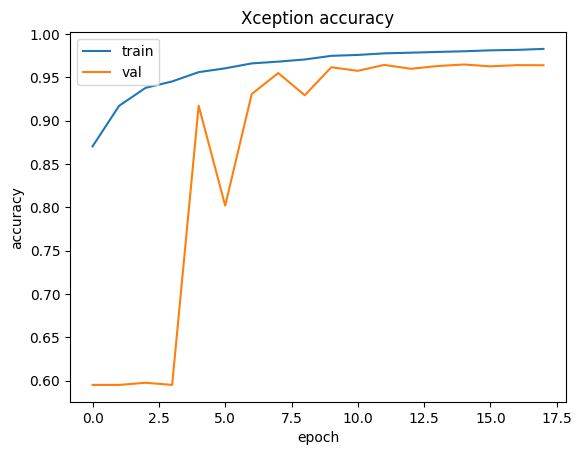

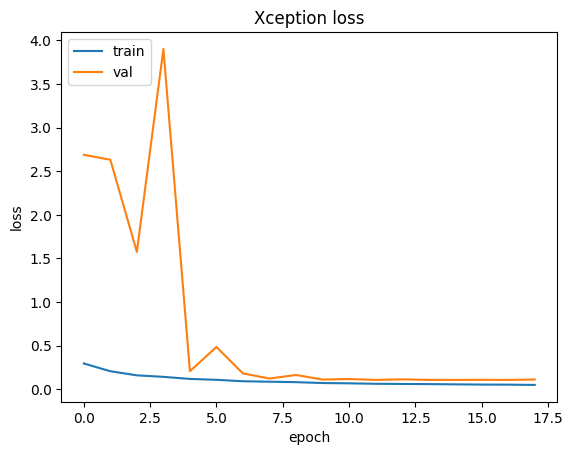

In [133]:
history = pd.read_csv(r'/Users/emilyhill/Documents/PCAM_dataset/histocancer_training.csv')

plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Xception accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Xception loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [306]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Cancer","Cancer"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

Below I load in my latest epoch save for my model to get predictions on the trained model. Above I just set up a function to create a confusion matrix out of two lists of predictions. 

In [217]:
loaded_model = keras.saving.load_model(r'/Users/emilyhill/Documents/PCAM_dataset/save_at_18.keras')
loaded_model.evaluate(val_flow)

1273/1273 [==============================] - 516s 405ms/step - loss: 0.1112 - acc: 0.9632


[0.11124341189861298, 0.9631986021995544]

In [218]:
out = loaded_model.predict(val_flow)

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x1af738f70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x1af738f70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: co

Since I choose None for the activation of my last dense layer the model is returning logits when predicting. I need to now apply sigmoid (1/(1+e^-x)) activation after to get probabilities out of the predictions. I did this below by using the tensorflow sigmoid function and then I round to 0 or 1 to get the prediction calss. 

In [252]:
val_pred = tf.round(tf.nn.sigmoid(out))
val_pred = np.array(val_pred).flatten()

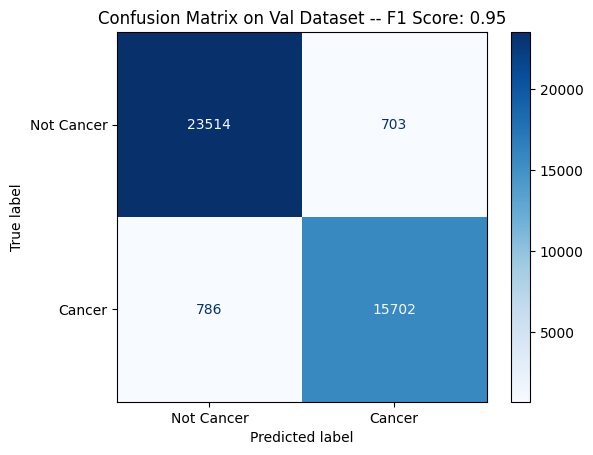

In [307]:
displayConfusionMatrix(y_val_true, val_pred, "Val")

In [257]:
results = metrics.accuracy_score(y_val_true, val_pred)
print('Validation Accuracy: ', round(results*100, 3), '%')

Validation Accuracy:  96.342 %


The confusion matrix above shows the results of the validation dataset predictions. Below I have printed the validation accuracy which is 96.34% and an F1 score 0f 95%. Now below I will get predictions for the test dataset and create my submission file. 

In [295]:
out = loaded_model.predict(test_flow)
test_pred = tf.round(tf.nn.sigmoid(out))
test_pred = np.array(test_pred).flatten()

1796/1796 [==============================] - 653s 363ms/step


In [303]:
test_pred.sum()
test['label'] = test_pred.astype(int)
test

/var/folders/9_/pf23by6s00s_thwh5hqqsp940000gn/T/ipykernel_24040/1229455446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['label'] = test_pred.astype(int)


,path,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif,0
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif,0
2,19709bec800f372d0b1d085da6933dd3ef108846.tif,0
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif,0
...,...,...
57453,2581931c6ef068f105a872f2c5500275fc678242.tif,0
57454,11b250a664d09ab59fd2afbdb2f8d786763b185d.tif,1
57455,18a6030935ec1ef1ce486ec51bc95abb4008fbf1.tif,0
57456,f541404e501e23a0188c852eb37eac94053cfdc0.tif,0


In [305]:
test_ids = [x.split('/')[-1].split('.')[0] for x in test_files]
submission = pd.DataFrame({'id':test_ids, 'label':test_pred.astype(int)})
submission.to_csv('Week3_cancer_submission.csv', index = False)

## Conclusion

The CNN that I created (Based on an xceptiopn network) worked well for this dataset. I ended up with voer 96% accuracy on my validation dataset and 87.34% accuracy on the test dataset in kaggle. I think I could have trained for a few more epochs if I changed the patience of my early stopper callback and potentially gotten slightly higher validation accuracy. Overall pretty happy with the results. 